## Numberplate reading custom model using Pre-trained object detection model

In [1]:
import os
import wget as wget
import tensorflow as tf

In [2]:
# #Making paths

CUSTOM_MODEL_NAME = 'my_ssd_mobnet'
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [3]:
# #Making paths

paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME),
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'),
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'),
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'),
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [4]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME),
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [5]:
# #Making paths

for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

In [6]:
# #cloning object detection models

if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}
else:
    print("file already exist")

file already exist


In [7]:
# # # Install Tensorflow Object Detection
#
# if os.name=='posix':
#     !apt-get install protobuf-compiler
#     !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .
#
# if os.name=='nt':
#     url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
#     wget.download(url)
#     !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
#     !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
#     os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))
#     !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
#     !cd Tensorflow/models/research/slim && pip install -e .

        1 file(s) moved.
        1 file(s) copied.
running build
running build_py
copying object_detection\protos\anchor_generator_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\argmax_matcher_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\bipartite_matcher_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\box_coder_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\box_predictor_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\calibration_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\center_net_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\eval_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\faster_rcnn_box_coder_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\faster_rcnn_pb2.py -> build\lib\object_detection\protos
copying object_detecti

zip_safe flag not set; analyzing archive contents...
object_detection.core.__pycache__.densepose_ops.cpython-39: module references __file__
object_detection.core.__pycache__.preprocessor.cpython-39: module MAY be using inspect.stack
object_detection.utils.__pycache__.autoaugment_utils.cpython-39: module MAY be using inspect.stack
error: Setup script exited with error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/



copying build\lib\nets\cyclegan.py -> build\bdist.win-amd64\egg\nets
copying build\lib\nets\cyclegan_test.py -> build\bdist.win-amd64\egg\nets
copying build\lib\nets\dcgan.py -> build\bdist.win-amd64\egg\nets
copying build\lib\nets\dcgan_test.py -> build\bdist.win-amd64\egg\nets
copying build\lib\nets\i3d.py -> build\bdist.win-amd64\egg\nets
copying build\lib\nets\i3d_test.py -> build\bdist.win-amd64\egg\nets
copying build\lib\nets\i3d_utils.py -> build\bdist.win-amd64\egg\nets
copying build\lib\nets\inception.py -> build\bdist.win-amd64\egg\nets
copying build\lib\nets\inception_resnet_v2.py -> build\bdist.win-amd64\egg\nets
copying build\lib\nets\inception_resnet_v2_test.py -> build\bdist.win-amd64\egg\nets
copying build\lib\nets\inception_utils.py -> build\bdist.win-amd64\egg\nets
copying build\lib\nets\inception_v1.py -> build\bdist.win-amd64\egg\nets
copying build\lib\nets\inception_v1_test.py -> build\bdist.win-amd64\egg\nets
copying build\lib\nets\inception_v2.py -> build\bdist.

You should consider upgrading via the 'C:\Users\MY-PC\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.



  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: slim
    Found existing installation: slim 0.1
    Uninstalling slim-0.1:
      Successfully uninstalled slim-0.1
  Running setup.py develop for slim


In [8]:
# # # verifying the installation
#
# VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# # Verify Installation
# !python {VERIFICATION_SCRIPT}

In [5]:
# #importing object detection model

import object_detection

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [6]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

### Detecting the Numberplate from Image

In [7]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [8]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [9]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'],'test','Cars432.png')

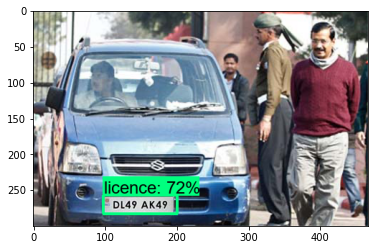

In [10]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.5)
            # agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [11]:
detections

{'detection_boxes': array([[0.8573977 , 0.20919593, 0.94120264, 0.43059796],
        [0.6665488 , 0.09395067, 0.769044  , 0.20019947],
        [0.6835597 , 0.5317155 , 0.7710015 , 0.63851523],
        [0.86957055, 0.21768595, 1.        , 0.44759363],
        [0.94768304, 0.9001016 , 0.9814996 , 0.9750915 ],
        [0.8062778 , 0.20219293, 0.9208382 , 0.439617  ],
        [0.96834147, 0.89184314, 0.99763393, 0.99772054],
        [0.9399288 , 0.9039024 , 0.9923149 , 0.9671836 ],
        [0.9244349 , 0.        , 0.9739499 , 0.03962524],
        [0.9535742 , 0.9169403 , 0.9911649 , 0.98400503],
        [0.10901818, 0.        , 0.5734478 , 1.        ],
        [0.87530726, 0.1302219 , 1.        , 0.42632526],
        [0.91688067, 0.        , 0.9864412 , 0.03045671],
        [0.94075495, 0.        , 0.98772365, 0.040976  ],
        [0.8944008 , 0.23666939, 0.9549877 , 0.4260784 ],
        [0.7207723 , 0.5188304 , 0.77670854, 0.6319653 ],
        [0.9652298 , 0.7751744 , 0.999484  , 0.874506

In [12]:
detections.keys()

dict_keys(['detection_boxes', 'detection_scores', 'detection_classes', 'raw_detection_boxes', 'raw_detection_scores', 'detection_multiclass_scores', 'detection_anchor_indices', 'num_detections'])

### Detecting Numberplate

In [13]:
import easyocr

detection_threshold = 0.5

In [14]:
image = image_np_with_detections
scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]

In [15]:
boxes

array([[0.8573977 , 0.20919593, 0.94120264, 0.43059796]], dtype=float32)

In [16]:
width = image.shape[1]
height = image.shape[0]

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[0.8573977  0.20919593 0.94120264 0.43059796]
[257.21930265  97.69449781 282.36079216 201.08924776]
[([[13, 7], [93, 7], [93, 23], [13, 23]], 'DL49 AK49', 0.6623832286175555)]


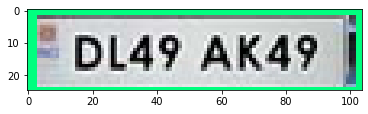

In [17]:
# Apply ROI filtering and OCR
for idx, box in enumerate(boxes):
    print(box)
    roi = box*[height, width, height, width]
    print(roi)
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    reader = easyocr.Reader(['en'])
    ocr_result = reader.readtext(region)
    print(ocr_result)
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))

In [18]:
for result in ocr_result:
    print(np.sum(np.subtract(result[0][2],result[0][1])))
    print(result[1])

16
DL49 AK49
